In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit import DataStructs
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing




import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, ParameterGrid
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import time




import warnings
warnings.filterwarnings('ignore')

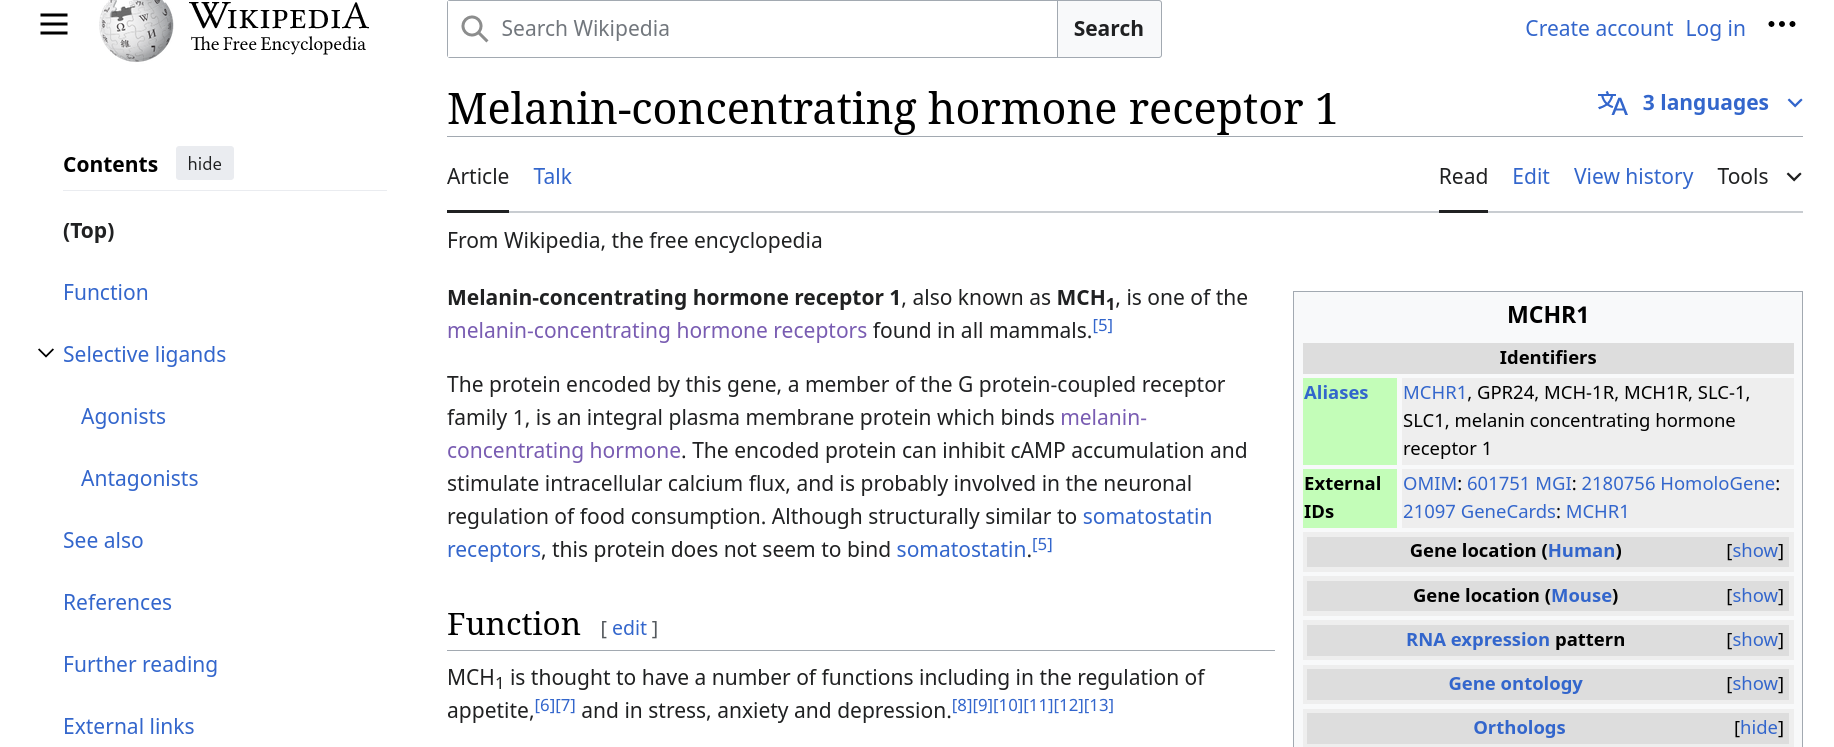

In [2]:
df_mchr1 = pd.read_csv("mchr1.csv",sep=";",on_bad_lines='warn')

In [3]:
df_zinc = pd.read_csv("world.csv")
df_zinc_backup = df_zinc

In [4]:
df_zinc.columns

Index(['zinc_id', 'smiles'], dtype='object')

In [5]:
df_mchr1.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties',
       'Action Type', 'Standard Text Value'],
 

In [7]:
print(df_mchr1['Standard Type'].notna().value_counts())
print(df_mchr1[df_mchr1['Standard Type'].notna()]['Standard Type'].value_counts())


Standard Type
True    5587
Name: count, dtype: int64
Standard Type
IC50                     3447
Ki                       1715
Inhibition                104
EC50                       83
Activity                   82
Kb                         69
pKb                        32
Imax                       29
Efficacy                    8
Emax                        6
pEC50                       4
Kd                          4
Bmax                        2
% Ctrl                      1
Mean fold stimulation       1
Name: count, dtype: int64


'\ndf_mchr1[df_mchr1[\'Standard Type\'] == "Activity"][[\'Molecule ChEMBL ID\', \'Molecule Name\', \'Molecule Max Phase\',\n       \'Molecular Weight\', \'#RO5 Violations\', \'AlogP\', \'Compound Key\',\n       \'Smiles\', \'Standard Type\', \'Standard Relation\', \'Standard Value\',\n       \'Standard Units\', \'pChEMBL Value\',\'Properties\',\n       \'Action Type\']]\n#df_mchr1\n'

# filter df

In [8]:
backup_df_mchr1 = df_mchr1

In [9]:
df_mchr1 = backup_df_mchr1[(backup_df_mchr1["Smiles"].notna()) & (backup_df_mchr1["pChEMBL Value"].notna()) & (backup_df_mchr1["Target ChEMBL ID"]=="CHEMBL344")]
print(len(backup_df_mchr1),len(df_mchr1),sep="\n")

5587
4678


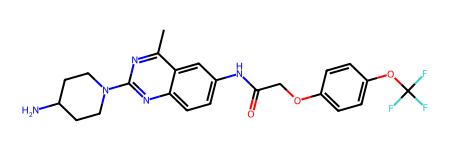

In [10]:
df_mchr1["Smiles"][0]
ligand_mols = df_mchr1.Smiles.apply(lambda x: Chem.MolFromSmiles(x))
Chem.MolFromSmiles(df_mchr1["Smiles"][0])
#df_mchr1.iloc[0]

Ensure that molecules in both datasets do not overlap 

In [11]:
print(len(df_zinc[df_zinc["smiles"].apply(lambda x: str(x).lower()).isin(df_mchr1["Smiles"].apply(lambda x: str(x).lower()))]))
print(len(df_mchr1[df_mchr1["Smiles"].apply(lambda x: str(x).lower()).isin(df_zinc["smiles"].apply(lambda x: str(x).lower()))]))

0
0


In [12]:
mchr1 = df_mchr1[["Molecule ChEMBL ID","Smiles","pChEMBL Value"]]
mchr1.rename({"Smiles":"smiles"},inplace=True,axis="columns")
mchr1.rename({"Molecule ChEMBL ID":"ID"},inplace=True,axis="columns")
zinc = df_zinc
zinc.rename({"zinc_id":"ID"},inplace=True,axis="columns")

zinc.reset_index(inplace=True)
mchr1.reset_index(inplace=True)

In [13]:
mchr1["mol"] = mchr1["smiles"].apply(lambda x: Chem.MolFromSmiles(x))
zinc["mol"] = zinc["smiles"].apply(lambda x: Chem.MolFromSmiles(x))

I will now add descriptors to both dataframes

In [14]:
for dataframe in [mchr1,df_zinc]:
    
    dataframe["rings"] = dataframe["mol"].apply(lambda x:len(Chem.GetSSSR(x)))
    dataframe["atomcount"] = dataframe["mol"].apply(lambda x:x.GetNumHeavyAtoms())
    dataframe["hba"] = dataframe["mol"].apply(lambda x:rdescriptors.CalcNumLipinskiHBA(x))
    dataframe["hbd"] = dataframe["mol"].apply(lambda x:rdescriptors.CalcNumLipinskiHBD(x))
    dataframe["molwt"] = dataframe["mol"].apply(lambda x:rdescriptors.CalcExactMolWt(x))
    dataframe["tpsa"] = dataframe["mol"].apply(lambda x:rdescriptors.CalcTPSA(x))
    dataframe["logp"] = dataframe["mol"].apply(lambda x:Descriptors.MolLogP(x))
    dataframe["rotatable"] = dataframe["mol"].apply(lambda x:Chem.CalcNumRotatableBonds(x))
    dataframe["heteroatoms"] = dataframe["mol"].apply(lambda x:rdescriptors.CalcNumHeteroatoms(x))
    dataframe["heterocycles"] = dataframe["mol"].apply(lambda x:rdescriptors.CalcNumHeterocycles(x))



In [15]:
mchr1.columns

Index(['index', 'ID', 'smiles', 'pChEMBL Value', 'mol', 'rings', 'atomcount',
       'hba', 'hbd', 'molwt', 'tpsa', 'logp', 'rotatable', 'heteroatoms',
       'heterocycles'],
      dtype='object')

In [16]:
mchr1.describe()

,index,pChEMBL Value,rings,atomcount,hba,hbd,molwt,tpsa,logp,rotatable,heteroatoms,heterocycles
count,4678.000000,4678.000000,4678.000000,4678.000000,4678.000000,4678.000000,4678.000000,4678.000000,4678.000000,4678.000000,4678.000000,4678.000000
mean,2778.341171,7.267809,4.482685,33.483968,5.869175,1.216118,467.257834,64.459609,4.885043,6.437153,7.386276,2.070329
std,1625.166554,0.994807,0.931948,5.096887,1.618918,1.127011,74.214843,22.925861,1.217922,2.252930,2.144901,1.123149
min,0.000000,4.000000,1.000000,13.000000,1.000000,0.000000,174.079313,3.240000,-3.452490,0.000000,2.000000,0.000000
25%,1368.250000,6.690000,4.000000,31.000000,5.000000,1.000000,423.155847,50.800000,4.026845,5.000000,6.000000,1.000000
50%,2747.500000,7.400000,5.000000,33.000000,6.000000,1.000000,463.207459,61.940000,4.823360,6.000000,7.000000,2.000000
75%,4214.750000,7.960000,5.000000,36.000000,7.000000,2.000000,512.160874,75.765000,5.665450,8.000000,9.000000,3.000000
max,5585.000000,10.470000,7.000000,168.000000,55.000000,38.000000,2419.121025,900.670000,9.846900,58.000000,59.000000,6.000000


In [17]:
zinc.describe()

,index,rings,atomcount,hba,hbd,molwt,tpsa,logp,rotatable,heteroatoms,heterocycles
count,5903.000000,5903.000000,5903.000000,5903.000000,5903.000000,5903.000000,5903.000000,5903.000000,5903.000000,5903.000000,5903.000000
mean,2951.000000,2.852109,25.301372,6.110622,2.599864,364.013428,89.920852,2.194337,5.065899,6.809927,1.222429
std,1704.193651,1.638753,11.106756,4.005350,2.452355,161.706616,63.318688,2.504172,4.251445,4.269646,1.196753
min,0.000000,0.000000,4.000000,0.000000,0.000000,56.026215,0.000000,-14.100400,0.000000,0.000000,0.000000
25%,1475.500000,2.000000,18.000000,3.000000,1.000000,260.173607,46.530000,0.834485,2.000000,4.000000,0.000000
50%,2951.000000,3.000000,24.000000,5.000000,2.000000,331.099062,74.570000,2.303500,4.000000,6.000000,1.000000
75%,4426.500000,4.000000,31.000000,8.000000,4.000000,437.169131,116.200000,3.754720,7.000000,9.000000,2.000000
max,5902.000000,11.000000,69.000000,35.000000,20.000000,993.441209,536.490000,18.470620,50.000000,43.000000,9.000000


In [18]:

mchr1["set"] = "chembl"
zinc["set"] = "zinc"
df = pd.concat([mchr1.drop(["smiles","pChEMBL Value","mol","ID"],axis="columns"),zinc.drop(["smiles","mol","ID"],axis="columns")]) #[["mol","rings","atomcount","hba","hbd","molwt","tpsa","logp","rotatable"]]
df

,index,rings,atomcount,hba,hbd,molwt,tpsa,logp,rotatable,heteroatoms,heterocycles,set
0,0,4,34,8,3,475.183124,102.60,3.78182,6,11,2,chembl
1,1,4,36,9,3,510.214617,108.48,4.28552,7,10,2,chembl
2,2,4,36,8,2,504.198440,96.81,4.59562,7,11,2,chembl
3,3,4,34,7,1,481.224453,70.59,4.77722,6,8,2,chembl
4,4,5,34,7,1,479.208803,70.59,4.67372,6,8,2,chembl
...,...,...,...,...,...,...,...,...,...,...,...,...
5898,5898,5,26,5,1,392.098477,59.06,2.34570,4,7,5,zinc
5899,5899,4,22,2,1,298.193280,37.30,3.63660,0,2,0,zinc
5900,5900,9,59,12,2,816.390971,133.87,5.07870,7,14,6,zinc
5901,5901,5,60,13,1,843.397391,139.72,6.16422,21,14,2,zinc


In [19]:
df_plot = pd.concat([mchr1.drop(["smiles","pChEMBL Value","mol"],axis="columns"),zinc.drop(["smiles","mol"],axis="columns")]) #[["mol","rings","atomcount","hba","hbd","molwt","tpsa","logp","rotatable"]]
combined_melted = pd.melt(df_plot, id_vars=['set'], value_vars=['logp', 'hba', 'hbd', 'rotatable', 'atomcount', 'rings'], var_name='var', value_name='val')

<Axes: xlabel='var', ylabel='val'>

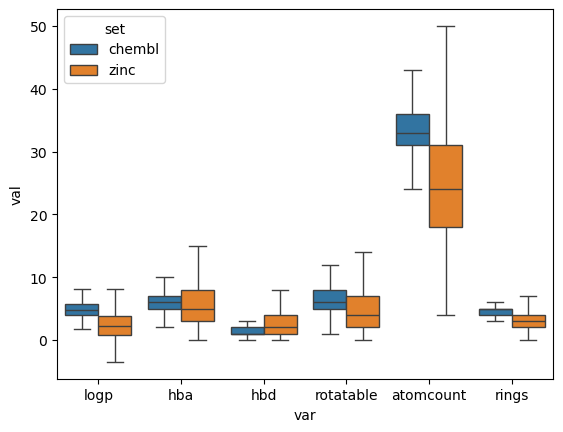

In [20]:
sns.boxplot(y='val', x='var',hue="set", data=combined_melted, showfliers=False)

In [21]:
melted_df2 = pd.melt(df, id_vars=['set'], value_vars=['molwt', 'tpsa'], var_name='var', value_name='val')

<Axes: xlabel='var', ylabel='val'>

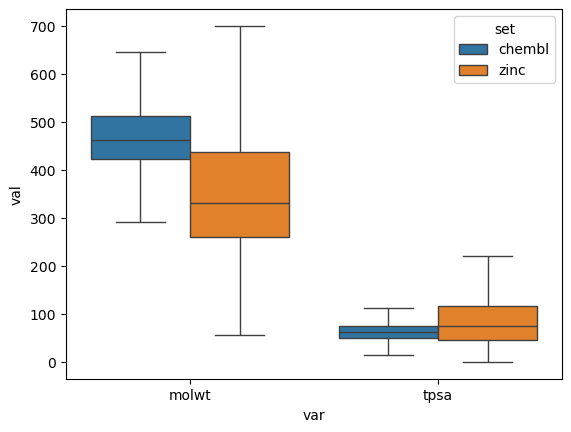

In [22]:
sns.boxplot(y='val', x='var',hue="set", data=melted_df2, showfliers=False)

In [23]:
melted_df2

,set,var,val
0,chembl,molwt,475.183124
1,chembl,molwt,510.214617
2,chembl,molwt,504.198440
3,chembl,molwt,481.224453
4,chembl,molwt,479.208803
...,...,...,...
21157,zinc,tpsa,59.060000
21158,zinc,tpsa,37.300000
21159,zinc,tpsa,133.870000
21160,zinc,tpsa,139.720000


In [24]:
smol = mchr1[mchr1["atomcount"] < 20].sort_values("atomcount").iloc[1]
zmol = zinc[zinc["atomcount"] < 9].iloc[1]

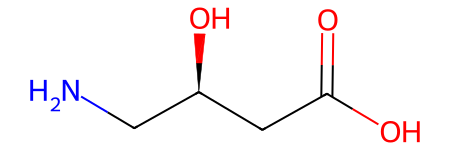

In [25]:
Chem.MolFromSmiles(smol["smiles"])
Chem.MolFromSmiles(zmol["smiles"])


MACCS KEYS

In [26]:
mchr1["maccs"] = mchr1.mol.apply(lambda x: MACCSkeys.GenMACCSKeys(x))
zinc["maccs"] = zinc.mol.apply(lambda x: MACCSkeys.GenMACCSKeys(x))


In [27]:
print(len(mchr1["maccs"][0].ToBitString()))
maccs_len = len(zinc["maccs"][3])
maccs_len

167


167

In [28]:
dict_maccs_sums = {"mchr1":([0]*maccs_len,mchr1["maccs"]),
                   "zinc":([0]*maccs_len,zinc["maccs"])}

for k,v in dict_maccs_sums.items():
    for macc in v[1]:
        for onbit in macc.GetOnBits():
            v[0][onbit] += 1

In [29]:
dict_maccs_sums["mchr1"][0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 64,
 0,
 0,
 99,
 0,
 5,
 1,
 1,
 0,
 26,
 0,
 417,
 0,
 0,
 546,
 26,
 57,
 474,
 0,
 12,
 277,
 2,
 4,
 0,
 121,
 135,
 2,
 0,
 436,
 1042,
 1167,
 1,
 1,
 498,
 1952,
 283,
 0,
 13,
 129,
 79,
 2,
 41,
 123,
 146,
 482,
 272,
 160,
 156,
 35,
 825,
 160,
 92,
 156,
 156,
 3182,
 35,
 145,
 3049,
 834,
 165,
 0,
 90,
 45,
 73,
 1060,
 159,
 850,
 3794,
 132,
 2721,
 74,
 2208,
 2809,
 519,
 1237,
 2726,
 343,
 4216,
 3890,
 2518,
 605,
 929,
 2171,
 1892,
 3435,
 2156,
 678,
 2020,
 2905,
 1756,
 3806,
 403,
 4183,
 2949,
 229,
 1548,
 2285,
 3252,
 2147,
 3252,
 1592,
 1819,
 4059,
 4248,
 1757,
 2700,
 514,
 1042,
 1645,
 4100,
 4236,
 109,
 3451,
 4396,
 4315,
 420,
 707,
 4663,
 2185,
 2861,
 3666,
 3933,
 206,
 1383,
 1799,
 3960,
 3256,
 3311,
 1323,
 4422,
 3981,
 513,
 700,
 889,
 4662,
 2861,
 2919,
 4629,
 1796,
 4348,
 4328,
 1853,
 2657,
 3447,
 2759,
 4349,
 4142,
 4044,
 4661,
 2789,
 4676,
 3232,
 3522,
 4677,
 4678,
 4678,
 4541,
 4678

In [30]:
dict_maccs_sums["mchr1_maccs_scaled"] = [x/maccs_len for x in dict_maccs_sums["mchr1"][0]]
dict_maccs_sums["zinc_maccs_scaled"] = [x/maccs_len for x in dict_maccs_sums["zinc"][0]]

In [31]:
dict_maccs_sums["zinc_maccs_scaled"][2:10]

[0.0, 0.023952095808383235, 0.0, 0.0, 0.0, 0.0, 0.9041916167664671, 0.0]

In [32]:
difference_in_maccs = pd.DataFrame({"num":range(1,maccs_len+1),"maccs_sum_diff":[(a-b) for a,b in zip(dict_maccs_sums["mchr1_maccs_scaled"], dict_maccs_sums["zinc_maccs_scaled"])]})

In [33]:
difference_in_maccs = difference_in_maccs[difference_in_maccs["maccs_sum_diff"] != 0]

Maccs more abundant in zinc dataset:

In [34]:
difference_in_maccs.sort_values("maccs_sum_diff")[:10]

,num,maccs_sum_diff
139,140,-20.269461
123,124,-13.053892
140,141,-12.425150
131,132,-12.395210
146,147,-12.149701
157,158,-12.113772
132,133,-9.538922
159,160,-9.431138
54,55,-9.035928
89,90,-8.922156


Maccs more abundant in Chembl dataset:

In [35]:
difference_in_maccs.sort_values("maccs_sum_diff",ascending=False)[:10]

,num,maccs_sum_diff
125,126,13.532934
133,134,12.790419
107,108,12.305389
86,87,12.023952
134,135,11.868263
75,76,11.820359
110,111,11.784431
62,63,11.700599
135,136,11.461078
117,118,11.191617


What do these numbers represent? from: https://github.com/openbabel/openbabel/blob/master/data/MACCS.txt

In [36]:
maccs_keys = pd.read_csv("maccs_dict.txt",sep=":")

In Zinc:

In [37]:
for i in difference_in_maccs.sort_values("maccs_sum_diff")[:20]["num"]:
    print("".join(str(maccs_keys.loc[i]["macc_keys"]).split(" ")[1:]).replace("#",""))

O>3(&...)FIX;incompletedefinition
QQ
CH3>2(&...)FIX;incompletedefinition
OACH2A
ACH2CH2A
C-N
A$A!N
CH3
OSO
QHAACH2A
CH3AACH2A
QCH2A
Heterocycle
NH
QHAAQH
ACH2AAACH2A
Anot%A%Anot%A
S=A
A!A$A!A
QS


In Chmebl:

In [38]:
for i in difference_in_maccs.sort_values("maccs_sum_diff",ascending=False)[:20]["num"]:
    print("".join(str(maccs_keys.loc[i]["macc_keys"]).split(" ")[1:]).replace("#",""))

A!O!A
X(HALOGEN)
CH3AAACH2A
X!A$A
Nnot%A%A
C=C(A)A
NACH2A
N=O
O=A>1
ACH2CH2A>1
CH2QCH2
A$A!O
OH
OCO
QCH3
8MRingorlarger.Thisonlyhandlesuptoringsizesof14
CC(C)(C)A
S
QHAQH
SA(A)A


# Finger prints:

In [ ]:
mchr1["ecfp"] = mchr1["mol"].apply(lambda x: Chem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))
zinc["ecfp"] = zinc["mol"].apply(lambda x: Chem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))

In [40]:
len(zinc["ecfp"][0])

1024

In [41]:
dict_ecfp_sums = {"mchr1":([0]*1024,mchr1["ecfp"]),
                   "zinc":([0]*1024,zinc["ecfp"])}

for k,v in dict_ecfp_sums.items():
    for ecfp in v[1]:
        for onbit in ecfp.GetOnBits():
            v[0][onbit] += 1

In [42]:
dict_ecfp_sums["mchr1_ecfp_scaled"] = [x/1024 for x in dict_ecfp_sums["mchr1"][0]]
dict_ecfp_sums["zinc_ecfp_scaled"] = [x/1024 for x in dict_ecfp_sums["zinc"][0]]

In [43]:
difference_in_ecfp = pd.DataFrame({"num":range(1,1024+1),"ecfp_sum_diff":[(a-b) for a,b in zip(dict_ecfp_sums["mchr1_ecfp_scaled"], dict_ecfp_sums["zinc_ecfp_scaled"])]})
difference_in_ecfp = difference_in_ecfp[difference_in_ecfp["ecfp_sum_diff"] != 0]

fingerprints more abundant in zinc dataset:

In [44]:
difference_in_ecfp.sort_values("ecfp_sum_diff")[:5]

,num,ecfp_sum_diff
807,808,-1.346680
1,2,-1.255859
36,37,-1.110352
147,148,-1.064453
389,390,-1.036133


fingerprints more abundant in Chembl dataset:

In [45]:
difference_in_ecfp.sort_values("ecfp_sum_diff",ascending=False)[:5]

,num,ecfp_sum_diff
875,876,2.029297
456,457,1.983398
935,936,1.818359
767,768,1.721680
191,192,1.414062


In [46]:
def substructures_of_bit_ecfp4_1024(mol, bit):
    bitinfo = {}
    Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, bitInfo=bitinfo)
    hit_atoms = [Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom)
                 for atom, radius in bitinfo.get(bit, [])
                 if radius > 0]
    submols = [Chem.PathToSubmol(mol, ha) for ha in hit_atoms]
    return submols

In [ ]:

tttt = []
for df,fp in [[zinc,808],[mchr1,876]]:
    print(fp)
    substructure_smiles = {}
    for ligand in zinc["mol"]:
        for submol in substructures_of_bit_ecfp4_1024(ligand, fp):
            #Draw.MolsToGridImage(submol)
            subsmiles = Chem.MolToSmiles(submol)
            substructure_smiles[subsmiles] = substructure_smiles.get(subsmiles, 0) + 1
    tttt.append(substructure_smiles)


In [48]:
tttt[0]

{'cc(c)C(O)(c(c)c)C(C)C': 4,
 'CN': 201,
 'CC(C)NC(C)C': 23,
 'cc(O)oc(c)c': 1,
 'C[C@H](C)CCC': 8,
 'CC(C)C': 2,
 'C[C@@H](C)CCC': 12,
 'CCC(=O)CC': 13,
 'cc(c)[C@@H](O)C(C)C': 2,
 'C[C@@H]1CCO1': 9,
 'cc(s)COC': 4,
 'cc(c)[C@H](O)C(C)C': 2,
 'CCC(CC)C(=O)O': 2,
 'cOCCN': 6,
 'CC(C)=CC(=O)O': 3,
 'cs/c(=N/C)n(C)n': 1,
 'cs/c(=N\\C)n(C)n': 1,
 'cc(s)C=C(C)C': 2,
 'cOCCn': 3,
 'cS(=O)(=O)NCl': 1,
 'C=Cc(c(c)C)n(c)[Sn]': 4,
 'CCCC(C)=N': 6,
 'ccc(nc)C(C)C': 2,
 'ccnn(c)C': 2,
 'cn(n)[C@H](OC)[C@@H](C)O': 1,
 'csc(=NC)n(C)n': 1}

In [49]:
tttt[1]

{'CN=C(NC)[C@H](C)O': 1,
 'C[C@@H](C)[C@@H]([C@@H](C)O)C(C)(C)O': 1,
 'C[C@@H](O)C[N+](C)(C)C': 1,
 'CC[C@@](C(C)C)(C(O)O)[C@@H](C)C': 4,
 'CC[C@@](C(C)C)(C(O)O)[C@H](C)C': 2,
 'cc(c)OCC': 4,
 'C[C@@H](C)[C@@H]([C@H](C)O)C(C)(C)O': 1,
 'ccc(cc)c(c)n': 7,
 'C[C@H](C)[C@@H]([C@@H](C)O)C(C)(C)O': 1,
 'C=CC(C)(C)C': 3,
 'ncc(F)c(n)O': 2,
 'C[C@H](O)[C@@H](O)[C@@H](C)O': 3,
 'ccc(OC)c(c)C': 3,
 'C=CCN(C)C': 3,
 'cc(C)cc(c)N': 2,
 'ccc(no)c(c)n': 2,
 'ccc(cc)-c(c)s': 2,
 'cc(n)[C@@H](CC)C(=O)O': 2,
 'C[C@@H](O)[C@@H](O)[C@@H](C)O': 1,
 'C[C@H](O)[C@H](O)[C@H](C)O': 1,
 'CN=C(NC)[C@@H](C)O': 1,
 'CC(C)[C@@H](C(N)=O)N(C)C': 1,
 'Cl[Sn]': 8,
 'CC(=O)OC(C)C': 3,
 'CN(C)C(=O)C(C)(c)C': 2,
 'cccc([N+])s': 1,
 'cc(n)[C@H](CC)C(=O)O': 2,
 'cCOB(c)O': 2,
 'CCC[C@@H](C)O': 1,
 'CCC[C@H](C)O': 1,
 'C[C@H](C)[C@@H]([C@H](C)O)C(C)(C)O': 1}

# MACCS tanimoto similarity search

In [187]:
def similarity_search(n,query_fp, searched_fp_set, cutoff=0.8):
    # we have no index, so we will have to just iterate through the entire searched set
    hits = []
    for i, fp in enumerate(searched_fp_set):
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
        if similarity >= cutoff: # similar enough for consideration
            hits.append((n,i, round(similarity,4)))
    return sorted(hits, key=lambda x: x[1], reverse=True) # stronger hits first

In [188]:
all_hits = []
for n,mch in enumerate(mchr1["mol"][:]):
    mch_fp = MACCSkeys.GenMACCSKeys(mch)
    hits = similarity_search(n,mch_fp, zinc["maccs"])
    if len(hits) > 0: all_hits.append(hits)


Hits: 

#mchr1   -|-   #zinc   -|-   sim_score

In [189]:
for n,i in enumerate(all_hits):
    if i[0][2] > 0.9:print(n,i)

20 [(152, 4735, 0.9322), (152, 2912, 0.8548), (152, 801, 0.8095), (152, 322, 0.8254)]
233 [(1169, 4445, 0.9091)]
357 [(1643, 4735, 0.9322), (1643, 2912, 0.8548), (1643, 801, 0.8095), (1643, 322, 0.8254)]


[(152, 4735, 0.9322), (152, 2912, 0.8548), (152, 801, 0.8095), (152, 322, 0.8254)]


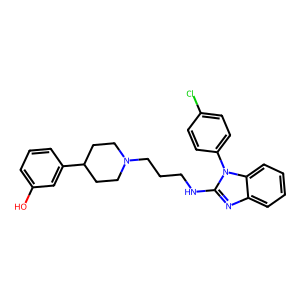

152


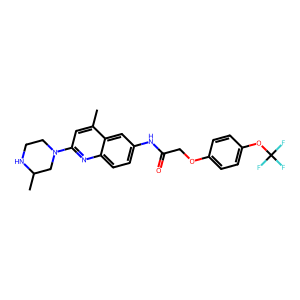

357


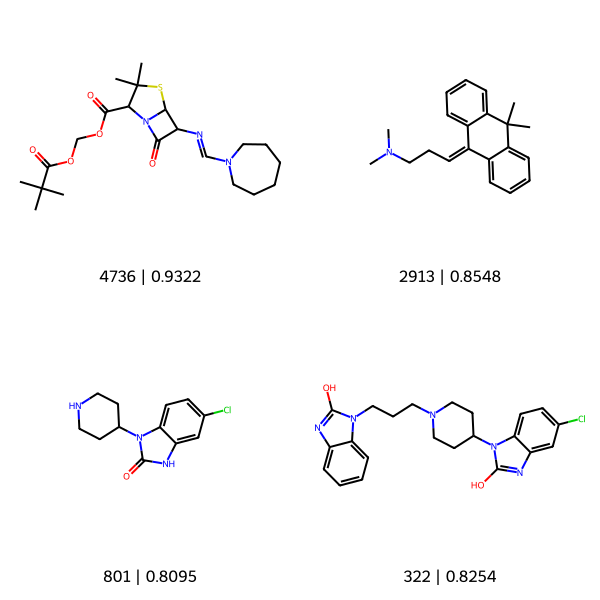

In [190]:
pic_hit = all_hits[20]
print(pic_hit)
display(Draw.MolToImage(mchr1["mol"].iloc[pic_hit[0][0]]))
print(mchr1.index[pic_hit[0][0]])
display(Draw.MolToImage(mchr1["mol"].iloc[357]))
print(mchr1.index[357])
for i in pic_hit:pass

Draw.MolsToGridImage([zinc["mol"][hit[1]] for hit in pic_hit],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=["{} | {}".format(zinc.index[hit[1]], hit[2]) for hit in pic_hit])

                     

Show best matches to molecules with high pChEMBL Value

In [191]:
best_1000_mols = mchr1.sort_values("pChEMBL Value",ascending=False)[:1000]
best_1000_mols.reset_index(inplace=True)


In [192]:
all_hits = []
for n,mch in enumerate(best_1000_mols["mol"][:]):
    mch_fp = MACCSkeys.GenMACCSKeys(mch)
    hits = similarity_search(n,mch_fp, zinc["maccs"])
    if len(hits) > 0: all_hits.append(hits)


In [193]:
big_len = 0
best_mol = None
for n,i in enumerate(all_hits):
    if i[0][2] > 0.8:
        if len(i) > big_len:
            big_len = len(i)
            best_mol = n,i
print(big_len)
print(best_mol)

16
(7, [(30, 5459, 0.8493), (30, 5326, 0.8493), (30, 4940, 0.8), (30, 4669, 0.831), (30, 4144, 0.8), (30, 3328, 0.8077), (30, 3221, 0.8077), (30, 3090, 0.8472), (30, 2389, 0.8056), (30, 1787, 0.8182), (30, 1782, 0.8182), (30, 1775, 0.8182), (30, 1774, 0.8182), (30, 1125, 0.8182), (30, 643, 0.8182), (30, 642, 0.8182)])


[(30, 5459, 0.8493), (30, 5326, 0.8493), (30, 4940, 0.8), (30, 4669, 0.831), (30, 4144, 0.8), (30, 3328, 0.8077), (30, 3221, 0.8077), (30, 3090, 0.8472), (30, 2389, 0.8056), (30, 1787, 0.8182), (30, 1782, 0.8182), (30, 1775, 0.8182), (30, 1774, 0.8182), (30, 1125, 0.8182), (30, 643, 0.8182), (30, 642, 0.8182)]


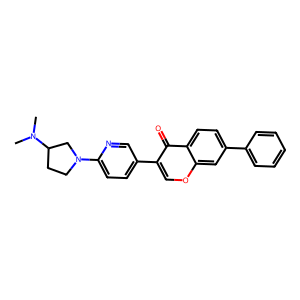

30


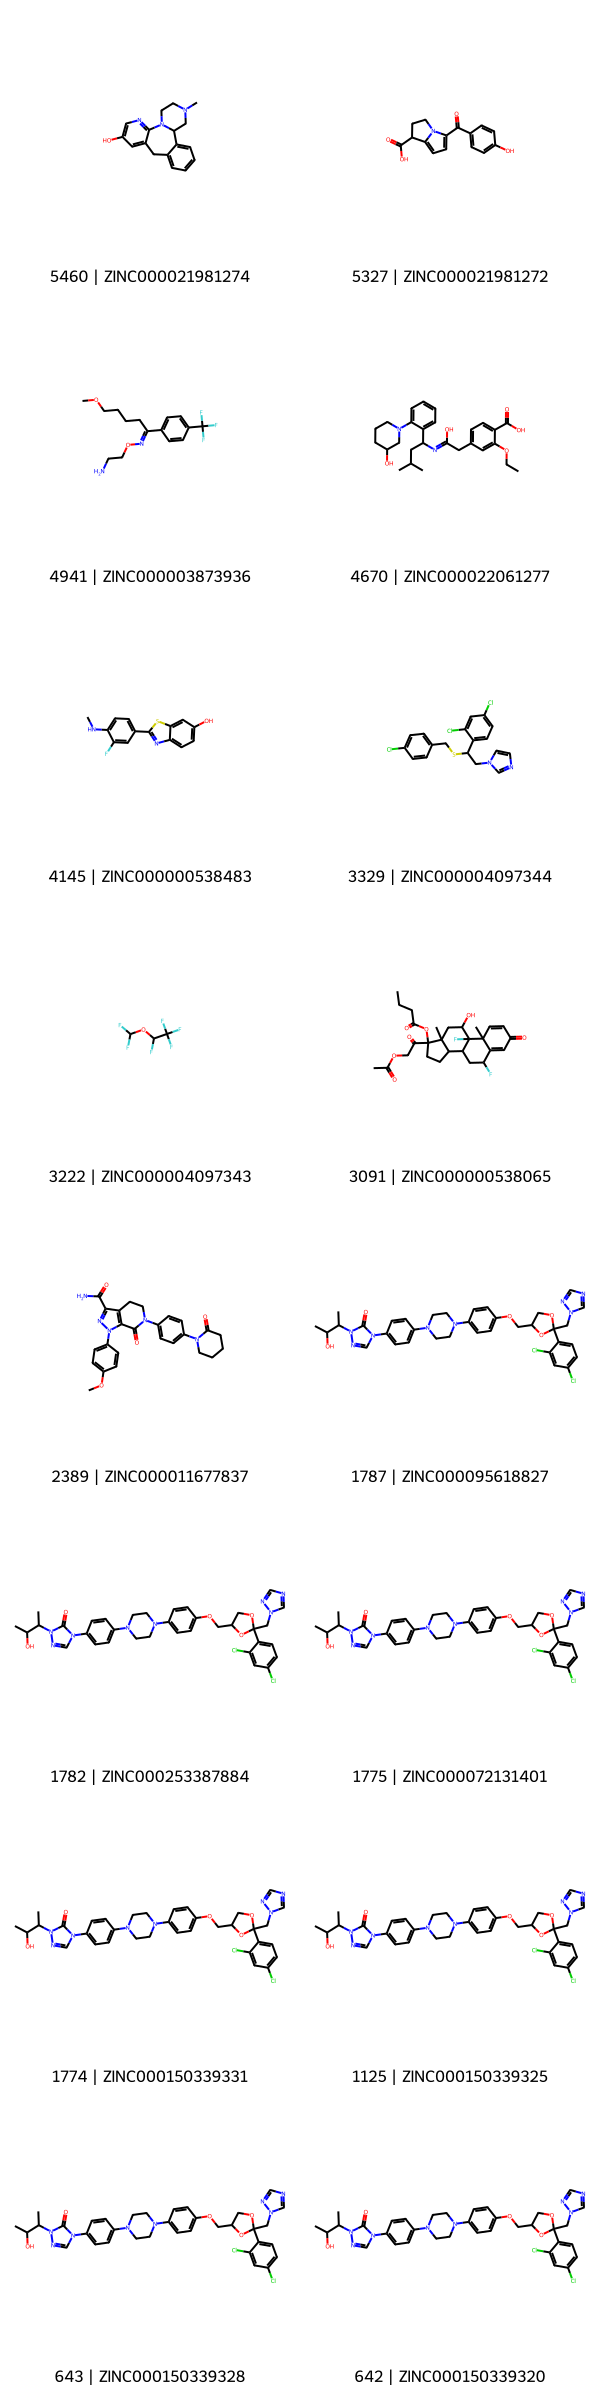

In [194]:
pic_hit = all_hits[7]
print(pic_hit)
display(Draw.MolToImage(mchr1["mol"].iloc[pic_hit[0][0]]))
print(mchr1.index[pic_hit[0][0]])
for i in pic_hit:pass

Draw.MolsToGridImage([zinc["mol"][hit[1]] for hit in pic_hit],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=["{} | {}".format(zinc.index[hit[1]],zinc.iloc[hit[1]]["ID"], hit[2]) for hit in pic_hit])

                     

# Scaffold

In [153]:
def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereo, doesn't matter much in scaffolds
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return scaff

zinc["scaffold"] = zinc["mol"].apply(lambda x: scaffold(x))
mchr1["scaffold"] = mchr1["mol"].apply(lambda x: scaffold(x))


[10:23:53] Explicit valence for atom # 1 C, 6, is greater than permitted


In [154]:
sum(mchr1["scaffold"].notna()), len(mchr1)," | ", sum(zinc["scaffold"].notna()), len(zinc)

(4678, 4678, ' | ', 5902, 5903)

In [155]:
zinc = zinc[zinc["scaffold"].notna()]
sum(zinc["scaffold"].notna()), len(zinc)

(5902, 5902)

In [156]:
zinc["scaff_smile"] = zinc["scaffold"].apply(lambda x: Chem.MolToSmiles(x))
mchr1["scaff_smile"] = mchr1["scaffold"].apply(lambda x: Chem.MolToSmiles(x))

In [63]:
len(list(zinc["scaff_smile"].value_counts()))

829

In [64]:
z_scaff_smiles,m_scaff_smiles = (zinc["scaff_smile"].value_counts()[:10]) , (mchr1["scaff_smile"].value_counts()[:10])
z_scaff_smiles,m_scaff_smiles

(scaff_smile
 C1CCCCC1                       740
                                377
 C1CCC2C(C1)CCC1C3CCCC3CCC21    328
 C1CCC(CC2CCCCC2)CC1            187
 C1CCC2CCCC2C1                  132
 C1CCCC1                        131
 C1CCC(C2CCCCC2)CC1             126
 C1CCC2CCCCC2C1                 118
 C1CCC(C2CCCC2)CC1              113
 C1CCC(CCC2CCCCC2)CC1            96
 Name: count, dtype: int64,
 scaff_smile
 C1CCC(CCCCC2CCC3CCCCC3C2)CC1                             168
 C1CCC(CCCCC2CCC3CC(C4CCCCC4)CCC3C2)CC1                   158
 C1CCC(CC2CCC(CCCCC3CCC(C4CCCCC4)CC3)CC2)CC1              155
 C1CCC(CCC2CCC(C3CCC4C(C3)CC3CCCCCC34)CC2)CC1              80
 C1CCC(C2CCC(CCC3CCC4CCCCC4C3)CC2)CC1                      74
 C1CCC(CCC2CCC(CCC3CCCCC3)CC2)CC1                          63
 C1CCC2CC(CCC3CCC(CC4CCC5CCCC5C4)CC3)CCC2C1                63
 C1CCC(CCCC2CCC3(C4CCCCC4)CC3C2)CC1                        60
 C1CCC(C2CCC(CCC3CCC4CC(CC5CCCC5)CCC4C3)CC2)CC1            58
 C1CCC(CCCCC2CCC(CC3CCC(CCC4

In [65]:
z_scaff_smiles

scaff_smile
C1CCCCC1                       740
                               377
C1CCC2C(C1)CCC1C3CCCC3CCC21    328
C1CCC(CC2CCCCC2)CC1            187
C1CCC2CCCC2C1                  132
C1CCCC1                        131
C1CCC(C2CCCCC2)CC1             126
C1CCC2CCCCC2C1                 118
C1CCC(C2CCCC2)CC1              113
C1CCC(CCC2CCCCC2)CC1            96
Name: count, dtype: int64

In [66]:
z_scaff_smiles.index

Index(['C1CCCCC1', '', 'C1CCC2C(C1)CCC1C3CCCC3CCC21', 'C1CCC(CC2CCCCC2)CC1',
       'C1CCC2CCCC2C1', 'C1CCCC1', 'C1CCC(C2CCCCC2)CC1', 'C1CCC2CCCCC2C1',
       'C1CCC(C2CCCC2)CC1', 'C1CCC(CCC2CCCCC2)CC1'],
      dtype='object', name='scaff_smile')

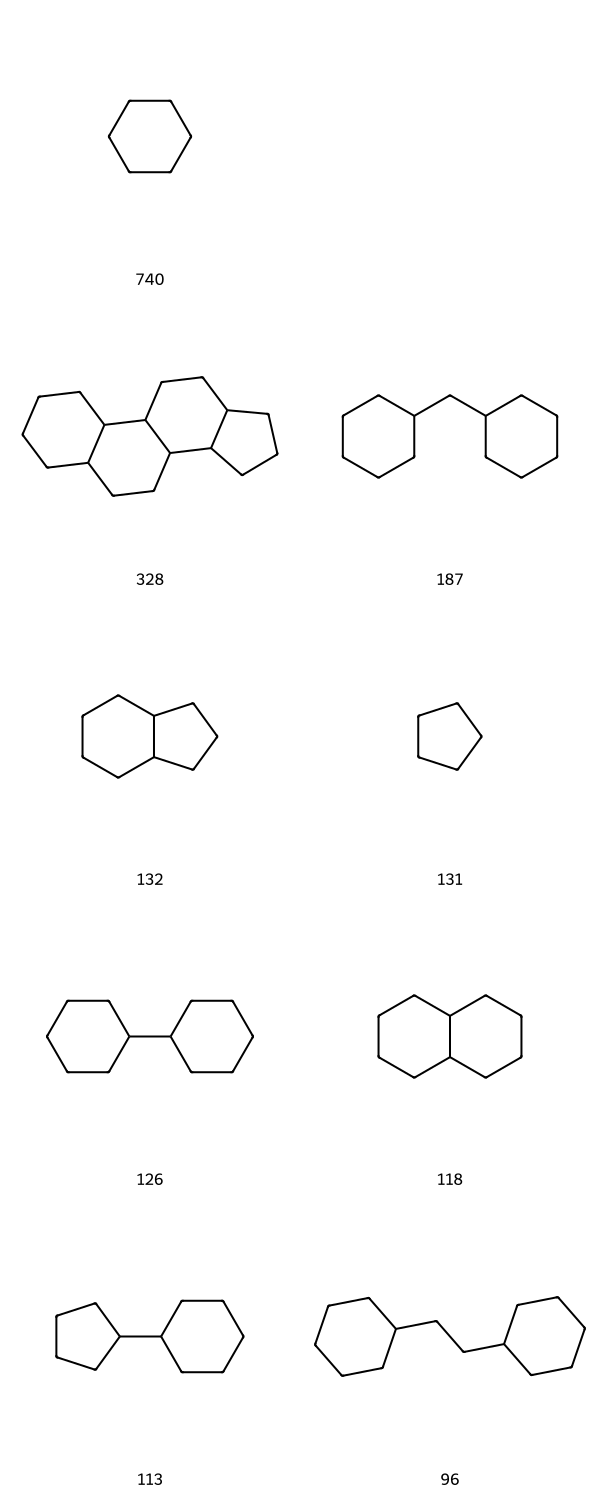

In [67]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaf) for scaf in list(z_scaff_smiles.index)],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(scaf) for scaf in list(z_scaff_smiles)])

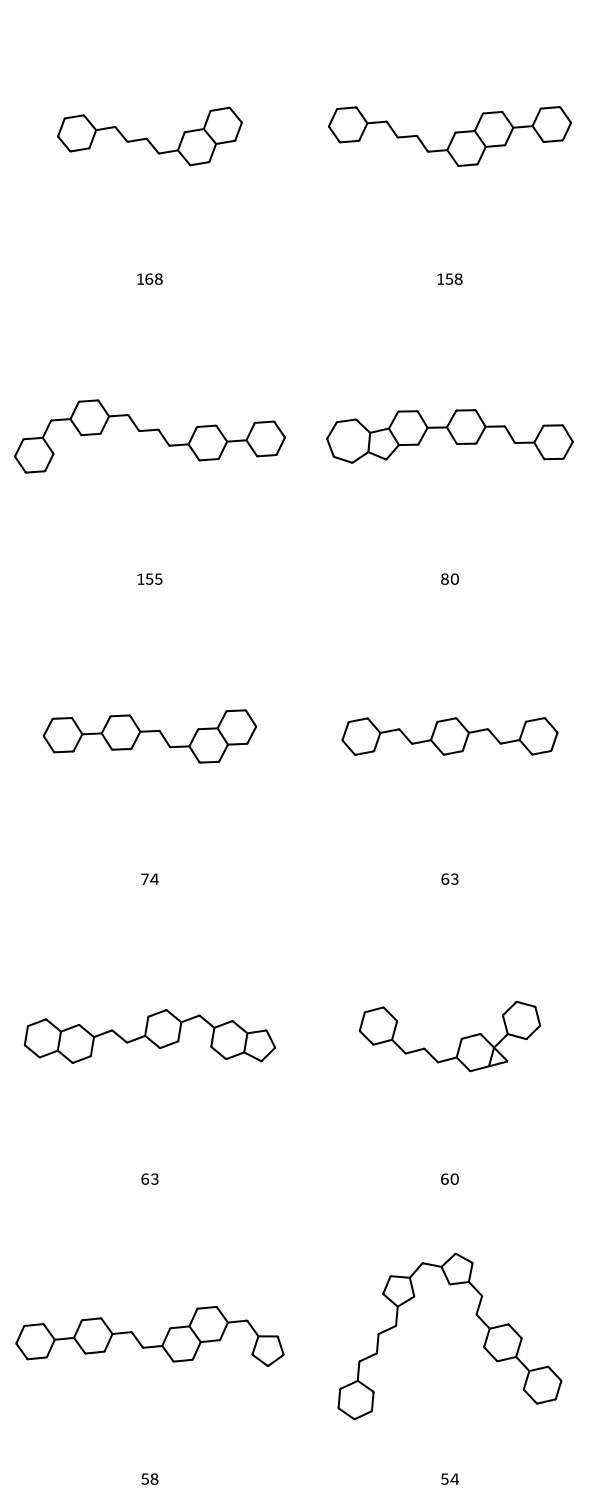

In [68]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaf) for scaf in list(m_scaff_smiles.index)],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(scaf) for scaf in list(m_scaff_smiles)])

# Visualization

In [42]:
zinc.columns

Index(['index', 'ID', 'smiles', 'mol', 'rings', 'atomcount', 'hba', 'hbd',
       'molwt', 'tpsa', 'logp', 'rotatable', 'heteroatoms', 'heterocycles',
       'set', 'maccs', 'ecfp'],
      dtype='object')

In [43]:
zinc_mqn = zinc.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in zinc["mol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )
mchr1_mqn = mchr1.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in mchr1["mol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [55]:
df_vis = pd.concat([zinc_mqn,mchr1_mqn],axis="rows")

In [57]:
list(df_vis.columns)
try:df_vis.reset_index(inplace=True)
except:pass
df_vis = df_vis.drop(["level_0","index","ID","smiles","mol","pChEMBL Value","set","maccs","ecfp",],axis="columns")

In [58]:
print(df_vis.columns)
df_dumb = pd.concat([zinc_mqn,mchr1_mqn],axis="rows")
df_dumb.reset_index(inplace=True)
df_vis["set"] = df_dumb["set"]

Index(['rings', 'atomcount', 'hba', 'hbd', 'molwt', 'tpsa', 'logp',
       'rotatable', 'heteroatoms', 'heterocycles', 'MQN_1', 'MQN_2', 'MQN_3',
       'MQN_4', 'MQN_5', 'MQN_6', 'MQN_7', 'MQN_8', 'MQN_9', 'MQN_10',
       'MQN_11', 'MQN_12', 'MQN_13', 'MQN_14', 'MQN_15', 'MQN_16', 'MQN_17',
       'MQN_18', 'MQN_19', 'MQN_20', 'MQN_21', 'MQN_22', 'MQN_23', 'MQN_24',
       'MQN_25', 'MQN_26', 'MQN_27', 'MQN_28', 'MQN_29', 'MQN_30', 'MQN_31',
       'MQN_32', 'MQN_33', 'MQN_34', 'MQN_35', 'MQN_36', 'MQN_37', 'MQN_38',
       'MQN_39', 'MQN_40', 'MQN_41', 'MQN_42'],
      dtype='object')


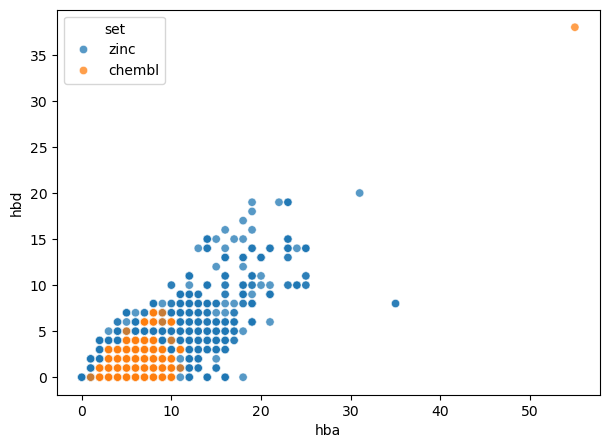

In [48]:
fig, ax = pyplot.subplots(figsize=(7,5))
p=sns.scatterplot(x="hba",
                      y="hbd",
                      data=df_vis,
                      hue="set",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

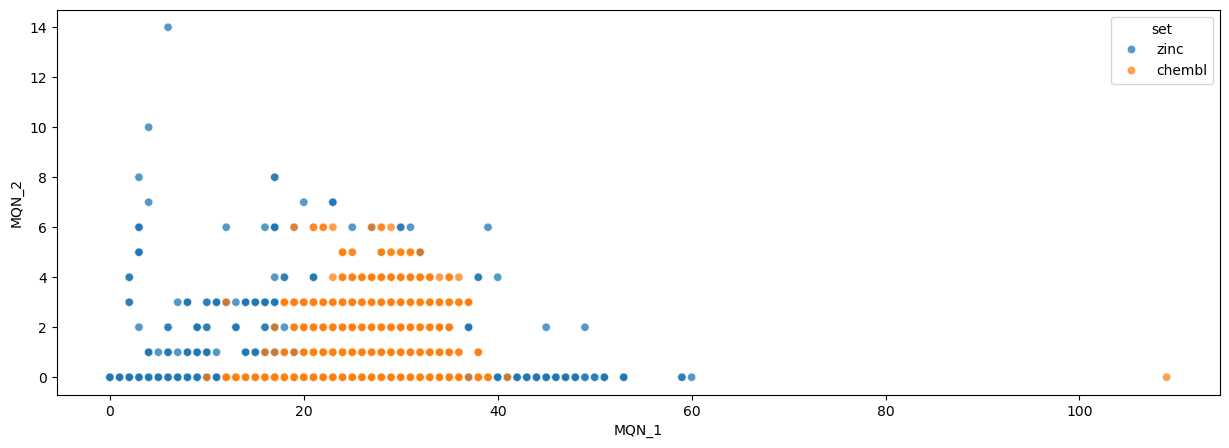

In [75]:
fig, ax = pyplot.subplots(figsize=(15,5))
p=sns.scatterplot(x="MQN_1",
                      y="MQN_2",
                      data=df_vis,
                      hue="set",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# PCA

In [59]:
df_vis = df_vis.fillna(-1)
df_vis = df_vis.drop("set",axis="columns")

len(df_vis.columns)

52

In [60]:
df_vis.columns

Index(['rings', 'atomcount', 'hba', 'hbd', 'molwt', 'tpsa', 'logp',
       'rotatable', 'heteroatoms', 'heterocycles', 'MQN_1', 'MQN_2', 'MQN_3',
       'MQN_4', 'MQN_5', 'MQN_6', 'MQN_7', 'MQN_8', 'MQN_9', 'MQN_10',
       'MQN_11', 'MQN_12', 'MQN_13', 'MQN_14', 'MQN_15', 'MQN_16', 'MQN_17',
       'MQN_18', 'MQN_19', 'MQN_20', 'MQN_21', 'MQN_22', 'MQN_23', 'MQN_24',
       'MQN_25', 'MQN_26', 'MQN_27', 'MQN_28', 'MQN_29', 'MQN_30', 'MQN_31',
       'MQN_32', 'MQN_33', 'MQN_34', 'MQN_35', 'MQN_36', 'MQN_37', 'MQN_38',
       'MQN_39', 'MQN_40', 'MQN_41', 'MQN_42'],
      dtype='object')

In [61]:
pca = PCA(n_components=27)
X_pca = pca.fit_transform(df_vis)
kumul_prev = 0
print("Komponenty:",end=" ")
for i, explained_variance_ratio in enumerate(pca.explained_variance_):
    kumul = pca.explained_variance_ratio_[0:i+1].sum()
    
    #print(f"{i + 1}. \tpodíl:{pca.explained_variance_ratio_[i]:.4f}",end=" ")
    print(f"{i + 1}.",end=" ")
    if kumul - kumul_prev > 0.01: 
        print("\nKumulovaný podíl:"+'\033[1m',round(kumul,4),'\033[0m',end=" ")
        kumul_prev = kumul
        print("\n\nKomponenty:",end=" ")
print("\nKumulovaný podíl:"+'\033[1m',round(kumul,4),'\033[0m',end=" ")

Komponenty: 1. 
Kumulovaný podíl: 0.9067  

Komponenty: 2. 
Kumulovaný podíl: 0.9939  

Komponenty: 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 
Kumulovaný podíl: 1.0  

In [62]:
pca = PCA(n_components=27)
pca.fit(df_vis)
df_vis_pca = pca.transform(df_vis)
df_vis_pca.shape
df_vis_pca_df = pd.DataFrame(df_vis_pca)
df_dumb = pd.concat([zinc_mqn,mchr1_mqn],axis="rows")
df_dumb.reset_index(inplace=True)
df_vis_pca_df["set"] = df_dumb["set"]


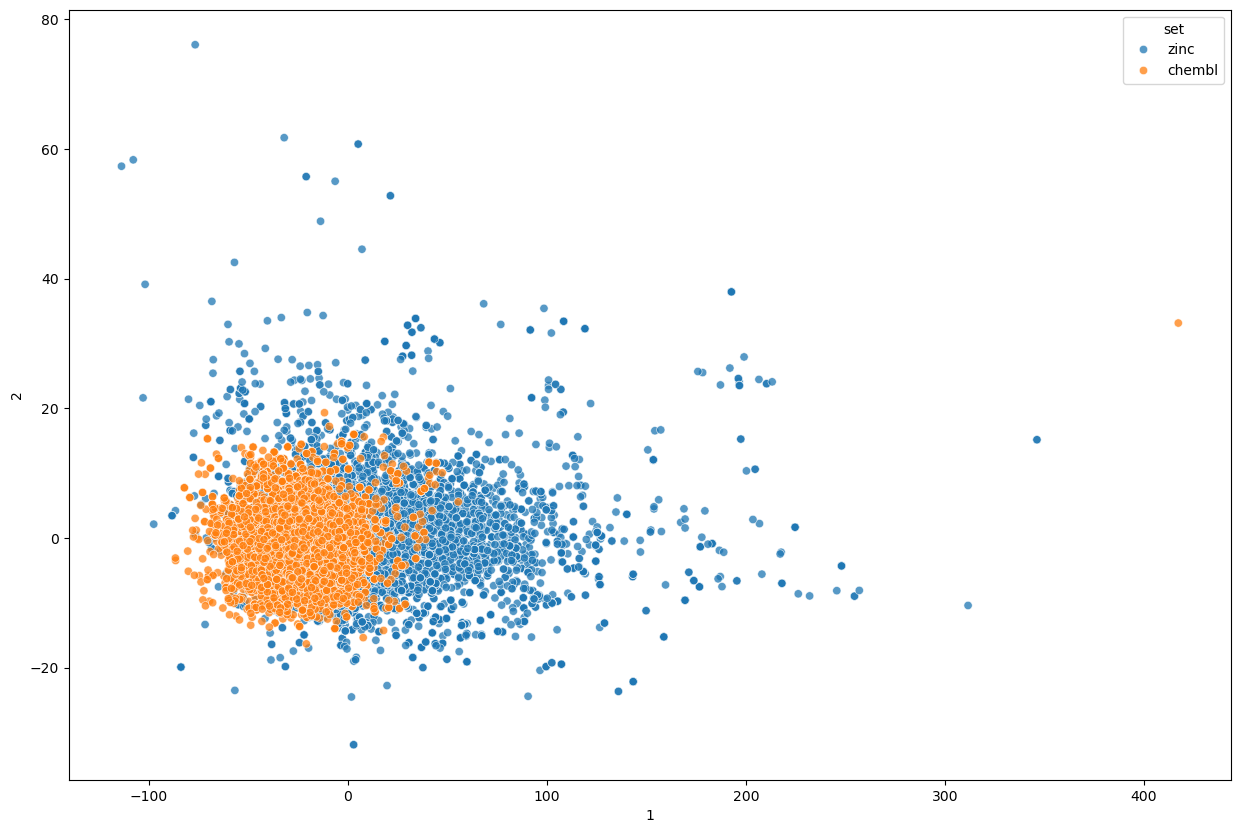

In [63]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x=1, y=2,
                      data=df_vis_pca_df,
                      hue="set",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# t-SNE

In [168]:
input()
#takes some time
sparse_mat = distance.pdist(list(df_dumb["ecfp"][:]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

In [169]:
#this too
clf = manifold.TSNE(n_components=2, metric="precomputed", init="random")
X_tsne = clf.fit_transform(dist_mat)

In [170]:
df_dumb = pd.concat([zinc_mqn,mchr1_mqn],axis="rows")
df_dumb.reset_index(inplace=True)
df_vis["set"] = df_dumb["set"]

In [171]:
df_vis = df_vis.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

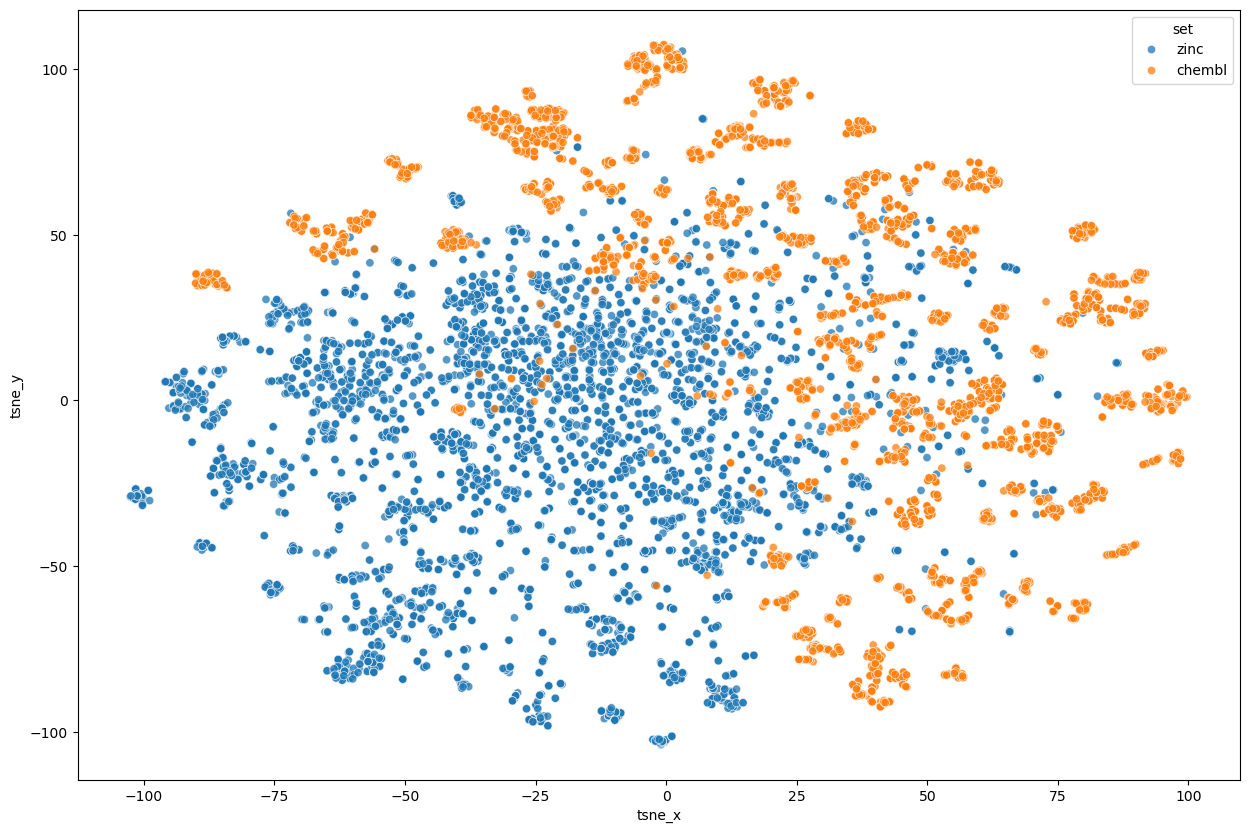

In [172]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df_vis,
                      hue="set",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# UMAP

In [173]:
import umap
reducer = umap.UMAP(metric="precomputed")
embedding = reducer.fit_transform(dist_mat)

In [174]:
df_vis = df_vis.join(pd.DataFrame(embedding, columns=["umap_x", "umap_y"]))

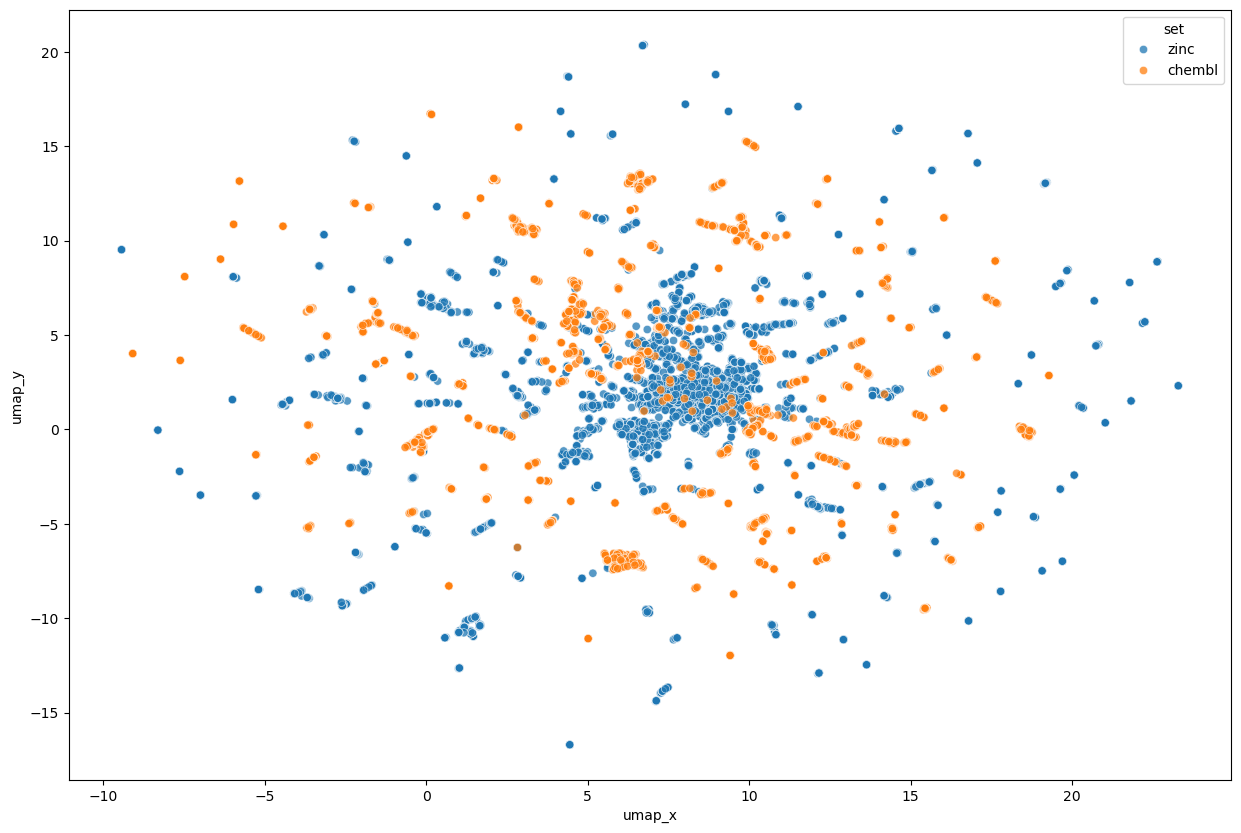

In [175]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="umap_x",
                      y="umap_y",
                      data=df_vis,
                      hue="set",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# Clasification

In [64]:
len(df_dumb["set"] == "chembl"]) == len(mchr1) , df_vis_pca_df.columns

(True,
 Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
           10,    11,    12,    13,    14,    15,    16,    17,    18,    19,
           20,    21,    22,    23,    24,    25,    26, 'set'],
       dtype='object'))

In [65]:
df_vis_pca_df["pChEMBL Value"] = df_dumb["pChEMBL Value"]

In [66]:
train_data = df_vis_pca_df[df_vis_pca_df["set"] == "chembl"]

In [92]:
train_data = df_dumb[df_dumb["set"] == "chembl"].drop(['level_0', 'index', 'ID', 'smiles', 'mol', 'maccs', 'ecfp'],axis="columns")
train_data

,rings,atomcount,hba,hbd,molwt,tpsa,logp,rotatable,heteroatoms,heterocycles,...,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42,pChEMBL Value
5903,4,34,8,3,475.183124,102.60,3.78182,6,11,2,...,0,0,4,0,0,0,0,2,1,7.66
5904,4,36,9,3,510.214617,108.48,4.28552,7,10,2,...,0,0,4,0,0,0,0,2,1,8.15
5905,4,36,8,2,504.198440,96.81,4.59562,7,11,2,...,0,0,4,0,0,0,0,2,1,6.94
5906,4,34,7,1,481.224453,70.59,4.77722,6,8,2,...,0,0,4,0,0,0,0,2,1,6.61
5907,5,34,7,1,479.208803,70.59,4.67372,6,8,2,...,0,1,4,0,0,0,0,2,1,6.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10576,5,36,6,1,486.251858,60.03,5.36960,8,6,2,...,0,1,4,0,0,0,0,2,1,6.57
10577,4,32,5,2,468.148367,57.26,5.84050,5,7,2,...,0,0,4,0,0,0,0,0,0,8.51
10578,4,30,4,0,399.231063,36.44,4.43970,5,4,1,...,0,0,4,0,0,0,0,2,1,6.85
10579,5,31,6,0,414.205576,52.29,3.99020,5,6,3,...,0,1,4,0,0,0,0,4,2,7.03


In [115]:
def f(x):
    if x<6:return 0
    else:return 1

In [116]:
train_data["pChEMBL class"] = train_data["pChEMBL Value"].apply(lambda x: int(x))
train_data["pChEMBL bin"] = train_data["pChEMBL Value"].apply(lambda x: f(x))

In [117]:
Xtrain, Xval, ytrain, yval = train_test_split(train_data.drop(["pChEMBL Value","set","pChEMBL class","pChEMBL bin"],axis="columns"), train_data["pChEMBL bin"], test_size=0.2, random_state=666)

In [100]:
import warnings
warnings.filterwarnings("ignore")
class noScale:
    def fit_transform(self,n):return(n)
    def transform(self,n):return(n)
scalers = {"minmax":MinMaxScaler(),"standard":StandardScaler(),"no scaler":noScale()}


In [118]:
from sklearn.ensemble import RandomForestClassifier
# Instantiate the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=666)
rf_classifier.fit(Xtrain, ytrain)

RandomForestClassifier(n_estimators=150, random_state=666)

Accuracy: 0.8878205128205128
Precision: 0.872314323607427
Recall: 0.8878205128205128
F1 Score: 0.8721304712603815


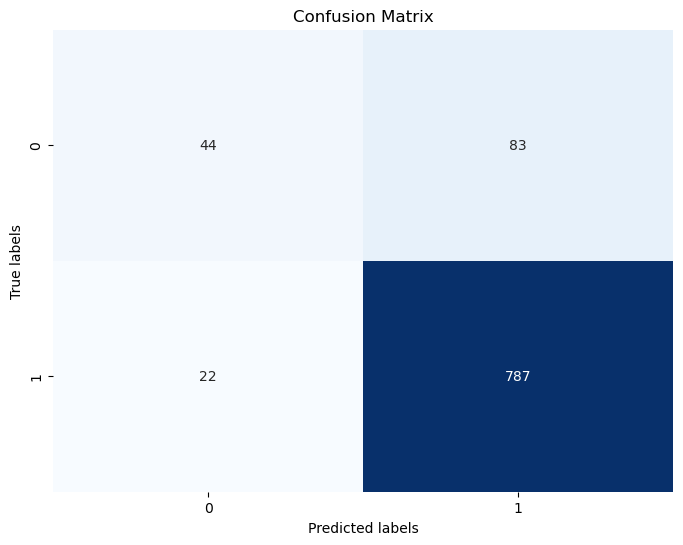

In [119]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

ypred = rf_classifier.predict(Xval)

# Calculate precision, recall, and F1 score                                                                                       
precision = precision_score(yval, ypred, average='weighted')                                                                                       
recall = recall_score(yval, ypred, average='weighted')                                                                                             
f1 = f1_score(yval, ypred, average='weighted')   
accuracy = accuracy_score(yval, ypred)                                                                                         

print(f"Accuracy: {accuracy}")                                                                                                                               
print(f"Precision: {precision}")                                                                                                  
print(f"Recall: {recall}")                                                                                                        
print(f"F1 Score: {f1}") 

conf_matrix = confusion_matrix(yval, ypred) 

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [141]:
Xtrain, Xval, ytrain, yval = train_test_split(train_data.drop(["pChEMBL Value","set","pChEMBL class","pChEMBL bin"],axis="columns"), train_data["pChEMBL Value"], test_size=0.2, random_state=666)

In [142]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate the Random Forest classifier
rf_regressor = RandomForestRegressor(n_estimators=150, random_state=666)
rf_regressor.fit(Xtrain, ytrain)

RandomForestRegressor(n_estimators=150, random_state=666)

In [143]:
ypred = rf_regressor.predict(Xval)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(yval, ypred)

# Calculate the Root Mean Squared Error (RMSE)
rmse = mse ** 0.5

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.7777156813541383


# Eval

In [144]:
eva = df_vis_pca_df[df_vis_pca_df["set"] == "zinc"]

In [145]:
eva = eva.drop(["set","pChEMBL Value"],axis="columns")

In [146]:
eva = df_dumb[df_dumb["set"] == "zinc"].drop(['level_0', 'index', 'ID', 'smiles', 'mol', 'maccs', 'ecfp',"set","pChEMBL Value"],axis="columns")
eva

,rings,atomcount,hba,hbd,molwt,tpsa,logp,rotatable,heteroatoms,heterocycles,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,0,14,6,6,240.023849,126.64,-0.80840,7,8,0,...,0,0,0,0,0,0,0,0,0,0
1,1,11,6,3,156.017107,103.54,-0.41400,1,6,1,...,0,0,0,1,0,0,0,0,0,0
2,1,12,2,2,205.059506,43.09,2.18580,5,4,1,...,0,0,1,0,0,0,0,0,0,0
3,1,26,5,4,368.256274,97.99,3.43300,12,5,0,...,0,0,1,0,0,0,0,0,0,0
4,4,31,11,3,462.078010,150.54,-0.22560,7,13,3,...,0,1,1,2,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5898,5,26,5,1,392.098477,59.06,2.34570,4,7,5,...,1,0,3,1,0,0,0,0,5,3
5899,4,22,2,1,298.193280,37.30,3.63660,0,2,0,...,0,0,1,3,0,0,0,0,6,3
5900,9,59,12,2,816.390971,133.87,5.07870,7,14,6,...,0,0,3,5,0,1,0,0,14,9
5901,5,60,13,1,843.397391,139.72,6.16422,21,14,2,...,0,0,1,4,0,0,0,0,2,1


In [147]:
#predikt eva
clf_for_eva = rf_regressor
clf_for_eva.fit(Xtrain, ytrain)
#print("předpovězená testovací přesnost:",metrics.accuracy_score(ytest, clf_for_eva.predict(best_Xtest_scaled)))

eva_pred = clf_for_eva.predict(eva)
zinc["pred"] = eva_pred
zinc["pred"]



0       5.617111
1       5.789726
2       5.638009
3       5.753318
4       6.302595
          ...   
5898    5.937887
5899    6.209548
5900    8.093424
5901    7.458984
5902    7.458984
Name: pred, Length: 5903, dtype: float64

In [148]:
zinc.sort_values("pred",ascending=False)[:5]

,index,ID,smiles,mol,rings,atomcount,hba,hbd,molwt,tpsa,logp,rotatable,heteroatoms,heterocycles,set,maccs,ecfp,pred
3155,3155,ZINC000085432549,CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...,<rdkit.Chem.rdchem.Mol object at 0x7fd67fd3c5f0>,9,60,14,3,824.399644,171.17,3.51750,8,14,6,zinc,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",8.299576
2300,2300,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,<rdkit.Chem.rdchem.Mol object at 0x7fd67fd17300>,9,65,16,4,882.406461,193.10,7.73150,11,16,5,zinc,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",8.240878
1941,1941,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,<rdkit.Chem.rdchem.Mol object at 0x7fd67fd26dc0>,9,65,16,4,881.422445,188.80,8.11600,11,16,6,zinc,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",8.219510
2561,2561,ZINC000008215434,Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(C[C@H](O)[C@H](O)...,<rdkit.Chem.rdchem.Mol object at 0x7fd67fd2bf40>,6,53,24,10,785.157135,362.93,-2.42396,13,26,5,zinc,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",8.205816
5076,5076,ZINC000085432544,CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...,<rdkit.Chem.rdchem.Mol object at 0x7fd67fb615b0>,9,59,13,3,810.420379,154.10,3.99090,7,13,6,zinc,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",8.164430


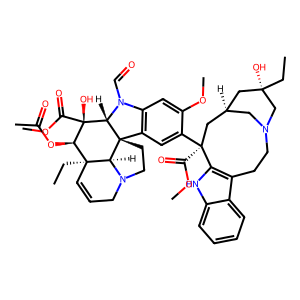

ZINC000085432549 8.2996
--------------------------------------------------


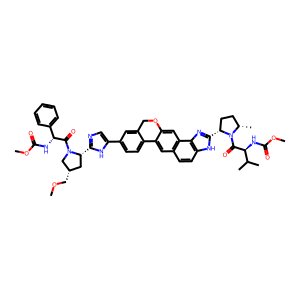

ZINC000203686879 8.2409
--------------------------------------------------


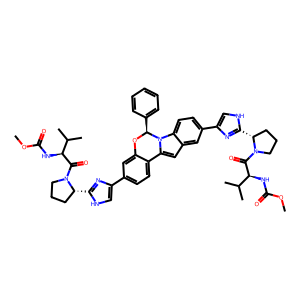

ZINC000150588351 8.2195
--------------------------------------------------


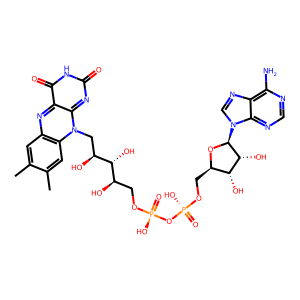

ZINC000008215434 8.2058
--------------------------------------------------


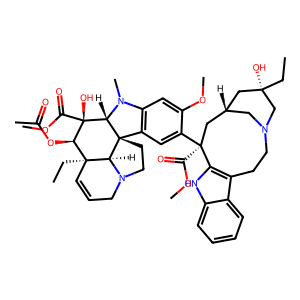

ZINC000085432544 8.1644
--------------------------------------------------


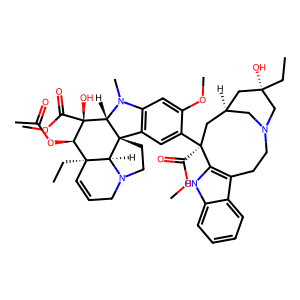

ZINC000085555528 8.1644
--------------------------------------------------


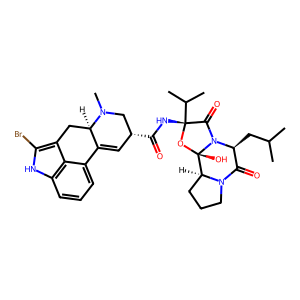

ZINC000053683151 8.1455
--------------------------------------------------


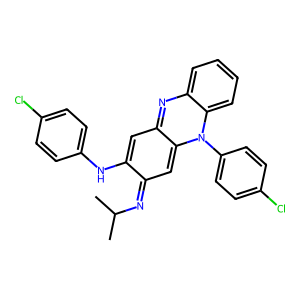

ZINC000017953024 8.1282
--------------------------------------------------


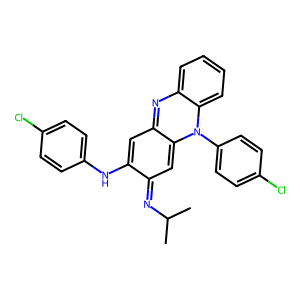

ZINC000253916263 8.1282
--------------------------------------------------


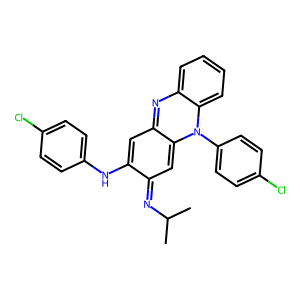

ZINC000100037101 8.1282
--------------------------------------------------


In [149]:
for n,i in zinc.sort_values("pred",ascending=False)[:10].iterrows():
    
    display(Draw.MolToImage(i["mol"]))
    print(i.ID,round(i.pred,4))
    print("-"*50)

In [ ]:
zinc["pred"]

In [137]:
Xtrain, Xval, ytrain, yval = train_test_split(train_data.drop(["pChEMBL Value","set","pChEMBL class","pChEMBL bin"],axis="columns"), train_data["pChEMBL bin"], test_size=0.2, random_state=666)

In [140]:
#predikt eva
clf_for_eva = rf_classifier
clf_for_eva.fit(Xtrain, ytrain)
#print("předpovězená testovací přesnost:",metrics.accuracy_score(ytest, clf_for_eva.predict(best_Xtest_scaled)))

eva_pred = clf_for_eva.predict(eva)
zinc["predcls"] = eva_pred
zinc["predcls"].value_counts()



pred
0    4067
1    1836
Name: count, dtype: int64

In [ ]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaf) for scaf in list(z_scaff_smiles.index)],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(scaf) for scaf in list(z_scaff_smiles)])

In [151]:
zinc.columns

Index(['index', 'ID', 'smiles', 'mol', 'rings', 'atomcount', 'hba', 'hbd',
       'molwt', 'tpsa', 'logp', 'rotatable', 'heteroatoms', 'heterocycles',
       'set', 'maccs', 'ecfp', 'pred'],
      dtype='object')

In [164]:
z_scaff_smiles_p,m_scaff_smiles_p = (zinc.sort_values("pred",ascending=False)[:100]["scaff_smile"].value_counts()[:10]) , (mchr1.sort_values("pChEMBL Value",ascending=False)[:100]["scaff_smile"].value_counts()[:10])
z_scaff_smiles_p,m_scaff_smiles_p

(scaff_smile
 C1CCC2C(C1)CCC2C1CCCC1                                            10
 C(CCCCCCC1CCC2CCCCC2C1CC1CCCCC1)CCCCCCC1CCC2CCCCC2C1CC1CCCCC1      7
 C1CC2CCC3C4CCCCC4CC3C(C3CCC4CC5CCC6CCCC7CCC5(C4C3)C67)CC(C1)C2     6
 C1CCCCCCCCC2CCC(C2)CC2CCCC2CCCCCCCC1                               5
 C1CCCCCCCCCC(CCC2CCCCC2)CCC2CCCCC2CCC2CCCC(CCCCCCCCC1)C2           4
 C1CCCCCCCCC2CC3CCC4CC(CCCCCCCC1)C(CCC1CCC(C5CCCC5)CC1)CC4C3C2      4
 C1CC2CC(C1)CC1C3CCCCC3CC1C(C1CCC3CC4CCC5CCCC6CCC4(C3C1)C56)C2      4
 C1CCCCCCCCCC(CC2CCC3CCCCC32)CC2CCCC2CCCCCCCCC1                     4
 C1CCC2CC3C(CCC4C3CC35CC6CCCC3C6CCC45)CC2C1                         4
 C1CCCCCCCC(C2CCCCC2)CCCCCCC1                                       4
 Name: count, dtype: int64,
 scaff_smile
 C1CCC(C(CCCCCC2CCC3(CC2)CCC2CCCCC23)C2CCCCC2)CC1      8
 C1CCC(C2CCC(CCC3CCC4CC(CC5CCCC5)CCC4C3)CC2)CC1        8
 C1CCC(CCCCC2(C3CCC(C4CCCCC4)CC3)CCCCC2)CC1            6
 C1CCC(C(CCCCCC2CCC3(CC2)CCC2CCCCC23)C2CCCC2)CC1       6
 C1CCC(CCCCCC2CCC(

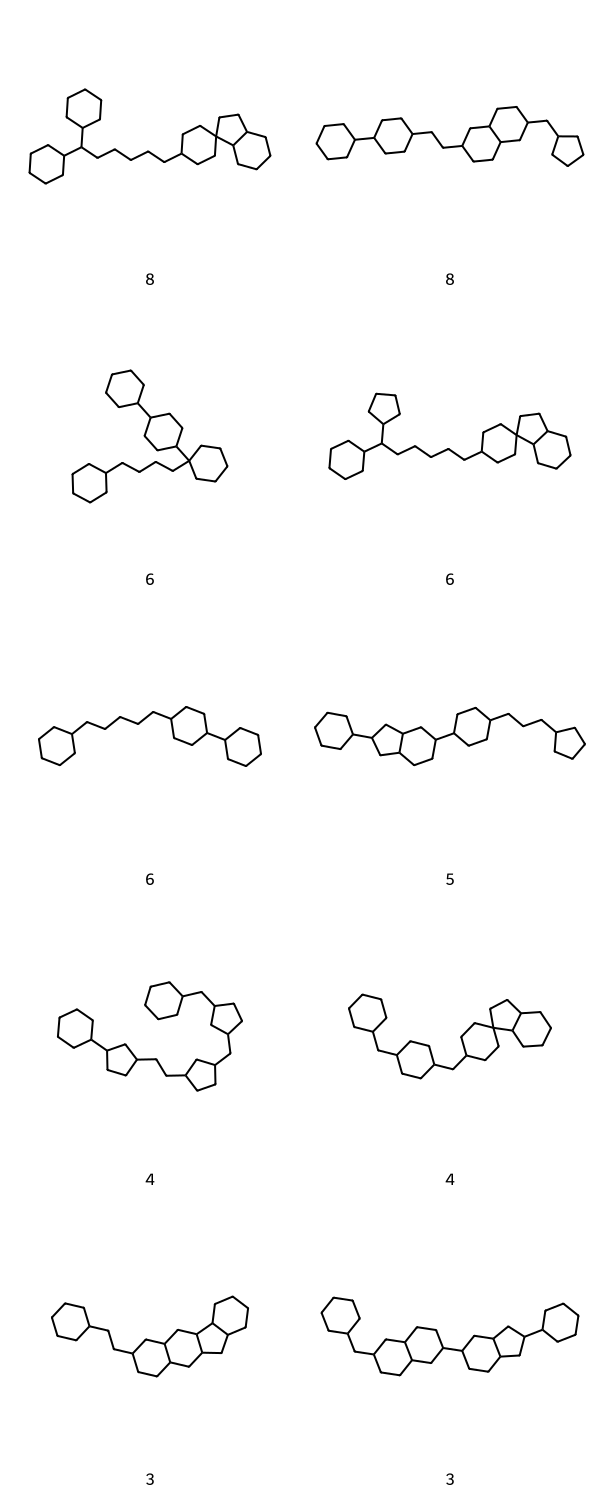

In [165]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaf) for scaf in list(m_scaff_smiles_p.index)],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(scaf) for scaf in list(m_scaff_smiles_p)])

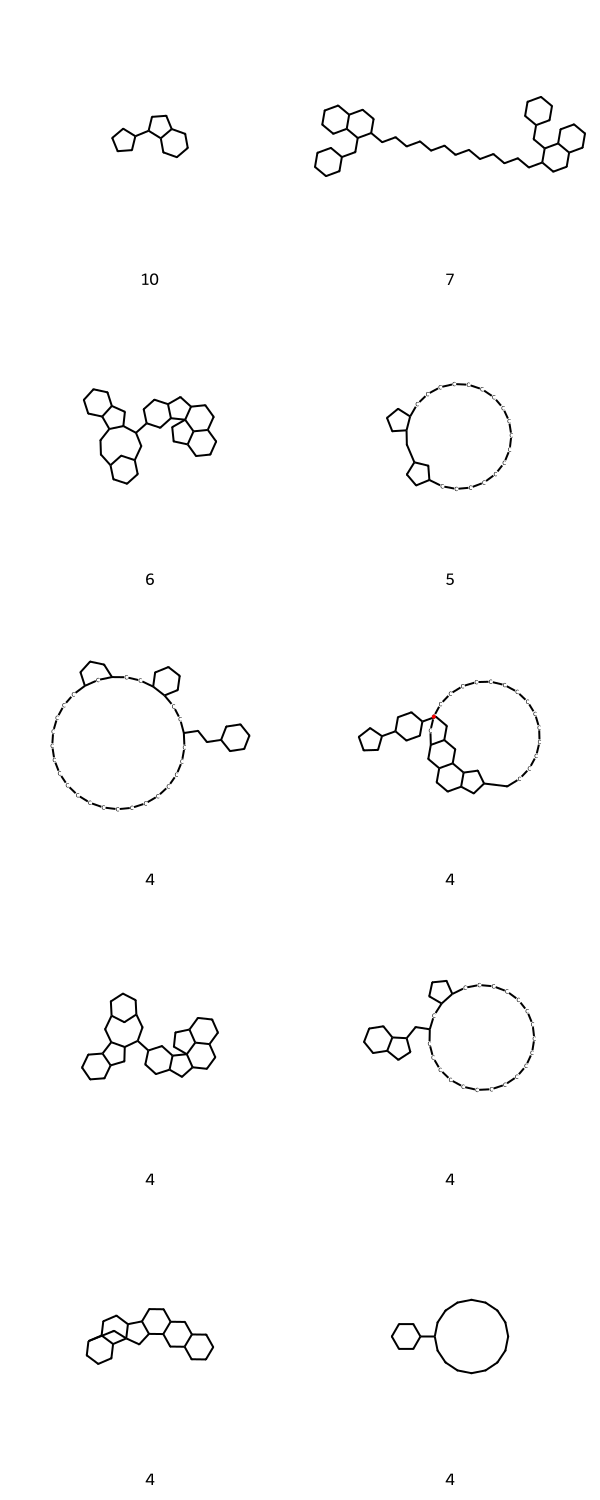

In [167]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaf) for scaf in list(z_scaff_smiles_p.index)],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(scaf) for scaf in list(z_scaff_smiles_p)])